In [1]:
import numpy as np

In [338]:
# data = np.load('../outputs/imputed_lora.npy')
# data_indicator = np.load('../outputs/imputed_lora_indicators.npy')

data = np.load('../outputs/imputed_lora_religion.npy')
data_indicator = np.load('../outputs/imputed_lora_indicators_religion.npy')


In [415]:
data.shape

(68371, 1652)

In [340]:
import pandas as pd

# load in variables of interest
raw_df = pd.read_feather("../data/data.feather")
test_items_df = pd.read_csv("../data/test_items.csv",index_col=0)
question_data = pd.read_csv("../data/question_data.csv", sep=';', index_col=0)
question_weights = pd.read_csv("../outputs/question_weights.csv", index_col=0)

In [342]:
# calculate the intelligence proxy

test_qs = [q for q in test_items_df.index if q in raw_df.columns]
iq_answered = raw_df[test_qs].notna().sum(axis=1)

scored_cols = []
for q in test_qs:
    correct_answer = test_items_df.loc[q].option_correct
    correct = raw_df[q].cat.codes+1 == correct_answer
    scored_cols.append(correct)

total_score= pd.concat(scored_cols, axis=1).sum(axis=1)
IQ_SCORES = total_score / iq_answered

In [425]:
# some metadata

gender=raw_df['gender'] == 'Man'
race = raw_df['race']
num_answered = raw_df.isna().values.sum(axis=1)

In [346]:
import cupy as cp

gpu_data = cp.array(data)

### what about just the most important features?

In [324]:
important_qs = [
 # 'q156918', # hindu
 # 'q156915', # buddhism
 'q21175',
 'q41099',
 'q45428',
 'q44384',
 'q44384',
 'q44384',
 'q60145',
 'q29055',
 'q29055',
 'q18763']

In [325]:
indices_important = np.array([i for i, (col, cat) in enumerate(multi_index) if col in important_qs])
VIP_data = gpu_data[:, indices_important]

In [326]:
VIP_data.shape

(68371, 27)

In [328]:
# Try an alternative visualization with t-SNE

tsne = TSNE(n_components=2, perplexity=50, random_state=42, n_neighbors=150)
tsne_result_VIP = tsne.fit_transform(VIP_data)
tsne_result_VIP_cpu = cp.asnumpy(tsne_result_VIP)

[2025-04-29 08:19:20.773] [CUML] [warning] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


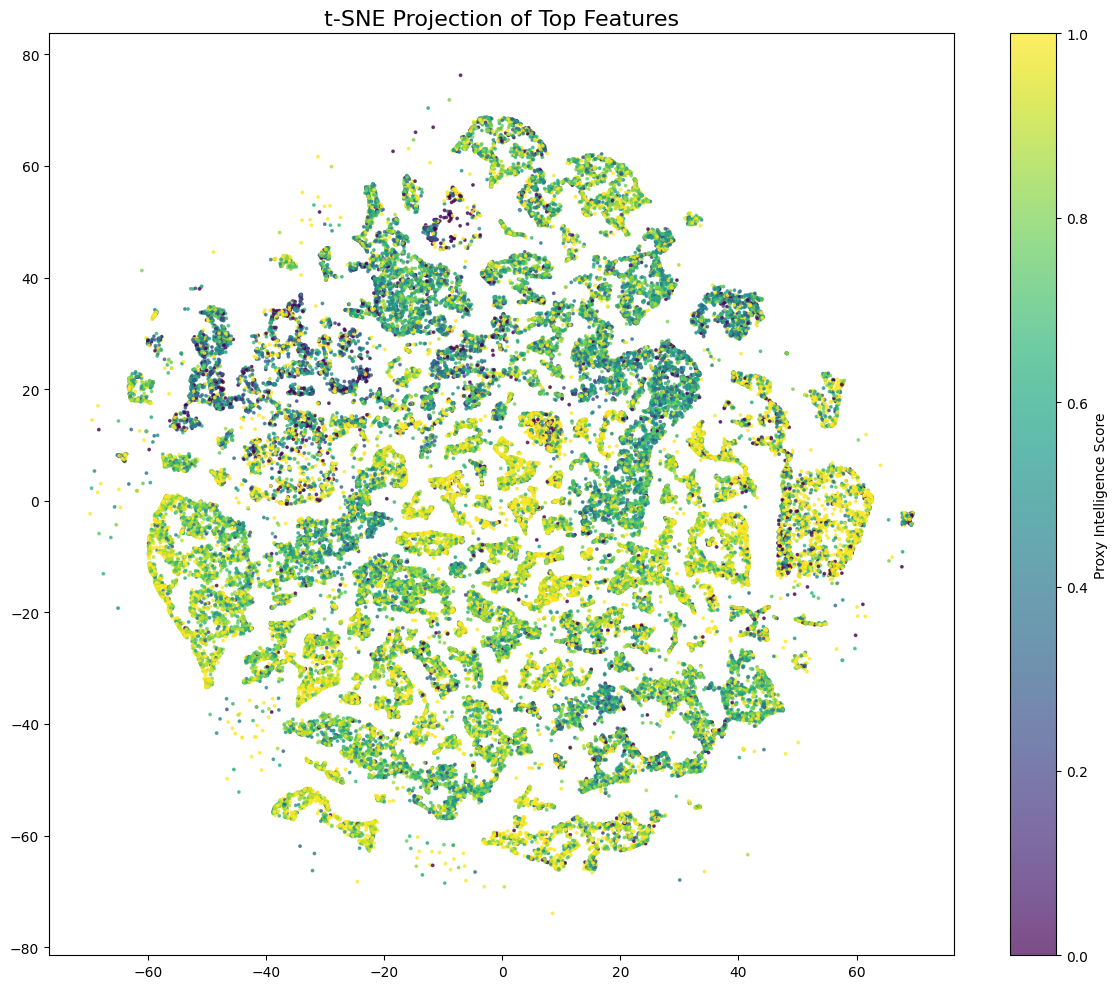

In [420]:
plt.figure(figsize=(12, 10))
scatter = plt.scatter(
    tsne_result_VIP_cpu[:, 0], 
    tsne_result_VIP_cpu[:, 1],
    # c=num_answered,
    # c=gender,
    # c= race.cat.codes,
    c=IQ_SCORES,
    cmap='viridis',
    # cmap = 'tab10',
    alpha=0.7,
    s=3
)
plt.colorbar(scatter, label='Proxy Intelligence Score')
plt.title('t-SNE Projection of Top Features', fontsize=16)
plt.tight_layout()
plt.savefig('../outputs/top_iq.pdf')
plt.show()

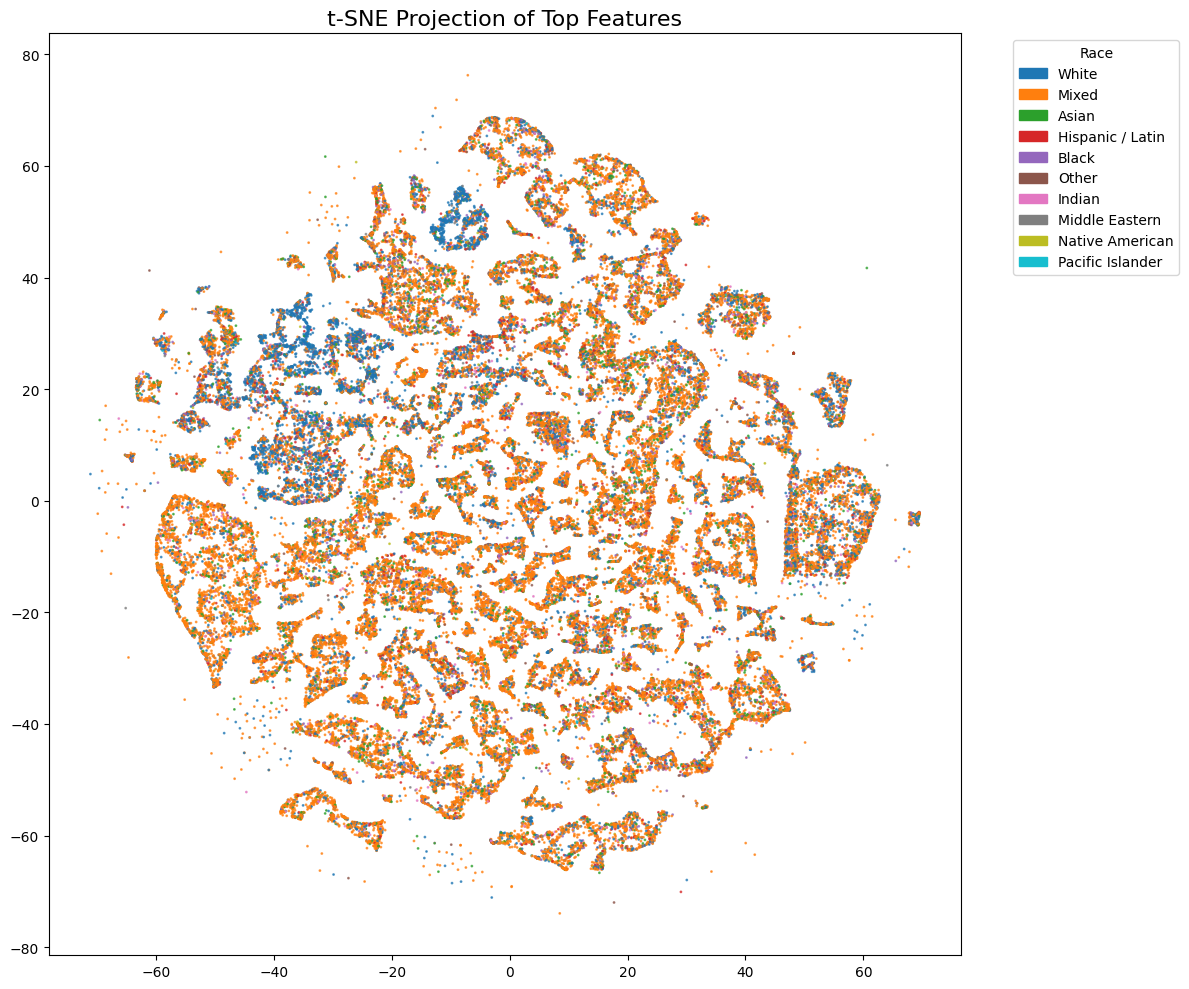

In [424]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Get the categories and their codes
race_categories = raw_df['race'].cat.categories

race_codes = raw_df['race'].cat.codes

# Create scatter plot
plt.figure(figsize=(12, 10))
scatter = plt.scatter(
    tsne_result_VIP_cpu[:, 0], 
    tsne_result_VIP_cpu[:, 1],
    c=raw_df['race'].cat.codes,
    cmap='tab10',
    alpha=0.7,
    s=1
)

# Create custom legend
handles = [
    mpatches.Patch(color=plt.cm.tab10(i / len(race_categories)), label=label)
    for i, label in enumerate(race_categories)
]
plt.legend(handles=handles, title='Race', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('t-SNE Projection of Top Features', fontsize=16)
plt.tight_layout()
plt.savefig("../outputs/top_race.pdf")
plt.show()

In [422]:
from cuml.cluster import HDBSCAN
import cupy as cp

# Initialize and fit HDBSCAN
vip_cluster = HDBSCAN(min_cluster_size=20)  # You can adjust min_cluster_size
cluster_labels_vip = vip_cluster.fit_predict(tsne_result_VIP)

# cluster_labels is now a CuPy array; if you want it on CPU:
cluster_labels_vip_cpu = cp.asnumpy(cluster_labels_vip)

# from cuml import KMeans

# kmeans_float = KMeans(n_clusters=40)
# cluster_labels_vip = kmeans_float.fit_predict(tsne_result_VIP)
# cluster_labels_vip_cpu = cp.asnumpy(cluster_labels_vip)

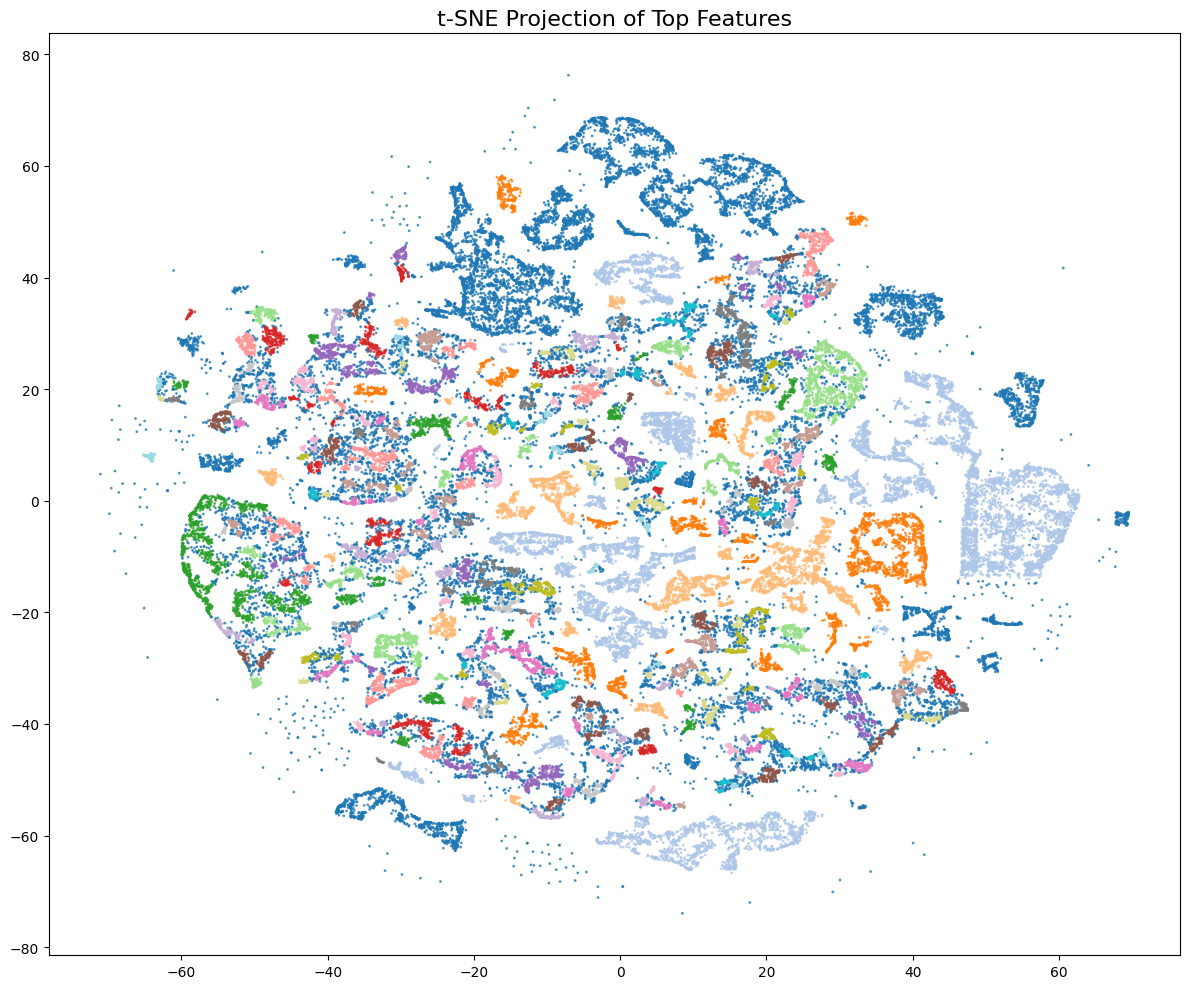

In [423]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Get the categories and their codes
religion_categories = raw_df['d_religion_type'].astype('category').cat.categories
religion_codes = raw_df['d_religion_type'].astype('category').cat.codes

# Create scatter plot
plt.figure(figsize=(12, 10))
scatter = plt.scatter(
    tsne_result_VIP_cpu[:, 0], 
    tsne_result_VIP_cpu[:, 1],
    c=cluster_labels_vip_cpu,
    cmap='tab20',
    alpha=0.7,
    s=1
)

# Create custom legend
# handles = [
#     mpatches.Patch(color=plt.cm.tab10(i / len(religion_categories)), label=label)
#     for i, label in enumerate(religion_categories)
# ]
# plt.legend(handles=handles, title='Religion', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('t-SNE Projection of Top Features', fontsize=16)
plt.tight_layout()
plt.savefig("../outputs/top_clusters.pdf")
bplt.show()

#### anova test on the iq over clusters

In [396]:
import numpy as np
from scipy.stats import f_oneway

# Convert to numpy arrays
labels = np.array(cluster_labels_vip_cpu)
scores = np.array(IQ_SCORES)

# Filter: exclude nan scores and -1 cluster
mask = (~np.isnan(scores)) & (labels != -1)
labels = labels[mask]
scores = scores[mask]

# Group scores by clusters
clusters = np.unique(labels)
grouped_scores = [scores[labels == cl] for cl in clusters]

# Run ANOVA
f_stat, p_val = f_oneway(*grouped_scores)
print("F-statistic:", f_stat)
print("p-value:", p_val)

F-statistic: 22.144829452065334
p-value: 0.0


#### chisq test on clusters and race

In [412]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency

# Assuming labels is your filtered clusters array (not including -1 or NaNs)
# And raw_df['race'].cat.codes holds race codes for the same indices

# Use the same mask as before to filter both arrays
mask = (raw_df['race'].notna().values) & (cluster_labels_vip_cpu != -1)
race_codes = raw_df['race'].cat.codes.values
filtered_races = race_codes[mask]
filtered_clusters = cluster_labels_vip_cpu[mask]

# Create contingency table
contingency = pd.crosstab(filtered_clusters, filtered_races)

# Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency)
print("Chi-square:", chi2)
print("p-value:", p)

Chi-square: 6975.671383256757
p-value: 5.551617748115959e-174


In [80]:
from scipy.stats import f_oneway

# Mask valid (non-NaN) entries
mask = ~np.isnan(IQ_SCORES)
valid_labels = cluster_labels_cpu[mask]
valid_scores = IQ_SCORES[mask]

groups = np.unique(valid_labels)
iq_by_cluster = [valid_scores[valid_labels == g] for g in groups]
f_stat, p_value = f_oneway(*iq_by_cluster)

print("F-statistic:", f_stat)
print("p-value:", p_value)

F-statistic: 6.492121064470616
p-value: 0.0


In [86]:
from scipy.stats import chi2_contingency

mask = (raw_df['d_religion_type'].notna()) & (cluster_labels_cpu!= -1)
valid_labels = cluster_labels_cpu[mask]
valid_religions = raw_df['d_religion_type'][mask]

# Suppose your DataFrame is called df with columns 'cluster' and 'religion'
contingency_table = pd.crosstab(valid_labels, valid_religions)

chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")

Chi-square statistic: 28353.774830774957
P-value: 0.0


In [87]:
contingency_table

d_religion_type   -  Agnosticism  Atheism  Buddhism  Catholicism  \
row_0                                                              
0                29            1        2         2            9   
1                 2            0        1         0            3   
2                13            3        3         2            2   
3                 7            0        0         0            3   
4                 7            3        1         0            2   
...              ..          ...      ...       ...          ...   
1256              9            6        3         1            2   
1257              3            3        4         0            0   
1258              4            0        5         0            1   
1259              5            3        6         0            1   
1260              4            3        4         0            0   

d_religion_type  Christianity  Hinduism  Islam  Judaism  Other  
row_0                                                           
0                          21         0      0        2      5  
1                           4         0      0        0      1  
2                           1         1      0        1      6  
3                          13         0      0        0      0  
4                           0         0      0        0      1  
...                       ...       ...    ...      ...    ...  
1256                        2         0      0        0      2  
1257                        1         0      0        2      2  
1258                        0         0      0        1      1  
1259                        0         0      0        0      0  
1260                        0         0      0        0      3  

[1261 rows x 10 columns]

In [110]:
from scipy.stats import chi2_contingency

mask = (raw_df['q134'].notna()) & (raw_df['d_religion_type'].notna()) & (raw_df['d_religion_type'] != "-")
valid_labels = raw_df['q134'][mask]
valid_religions = raw_df['d_religion_type'][mask]

# Suppose your DataFrame is called df with columns 'cluster' and 'religion'
contingency_table = pd.crosstab(valid_labels, valid_religions)

chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")

Chi-square statistic: 3015.9545719351695
P-value: 0.0


In [111]:
contingency_table

d_religion_type  Agnosticism  Atheism  Buddhism  Catholicism  Christianity  \
q134                                                                         
Yes                     1186     1176       155         1572          2893   
No                      5168     6486       508         1442          3066   

d_religion_type  Hinduism  Islam  Judaism  Other  
q134                                              
Yes                    58     69      282   1141  
No                     94     72      751   3509

### mca

In [62]:
from collections import defaultdict

# Example: pairs = [('q1', 'a'), ('q1', 'b'), ('q2', 'a'), ...]
# data = numpy array, columns correspond to pairs

# Group column indices by question
question_to_indices = defaultdict(list)
for idx, (q, a) in enumerate(pairs):
    question_to_indices[q].append(idx)

# Split matrix: dict of question -> submatrix
data_by_question = {q: data[:, idxs] for q, idxs in question_to_indices.items()}



In [64]:
import numpy as np

# data_by_question: dict where each value is a (n_samples, n_answers) array

onehot_by_question = {
    q: (arr == arr.max(axis=1, keepdims=True)).astype(int)
    for q, arr in data_by_question.items()
}

# Concatenate along the feature axis (columns)
hard_onehot_matrix = np.concatenate(list(onehot_by_question.values()), axis=1)

In [69]:
hard_one_hot_with_indicators = pd.DataFrame(np.concat([hard_onehot_matrix, data_indicator[:, 1661:]], axis=1))

In [309]:
import prince

subsample = hard_one_hot_with_indicators.sample(n=5000, random_state=42)
# subsample = pd.DataFrame(hard_onehot_matrix).sample(n=5000, random_state=42)
zero_sum_cols = subsample.columns[subsample.sum(axis=0) == 0]
print("Zero-sum columns:", zero_sum_cols.tolist())
subsample = subsample.drop(columns=zero_sum_cols)

mca = prince.MCA(
    n_components=100,
    n_iter=3,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42,
    one_hot=False
)
mca_features = mca.fit_transform(subsample)


Zero-sum columns: [1987, 2090]


In [310]:
umap_mca = UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
umap_features = umap_mca.fit_transform(mca_features)
_for_plotting = umap_features.values

[2025-04-29 07:53:58.111] [CUML] [info] build_algo set to brute_force_knn because random_state is given


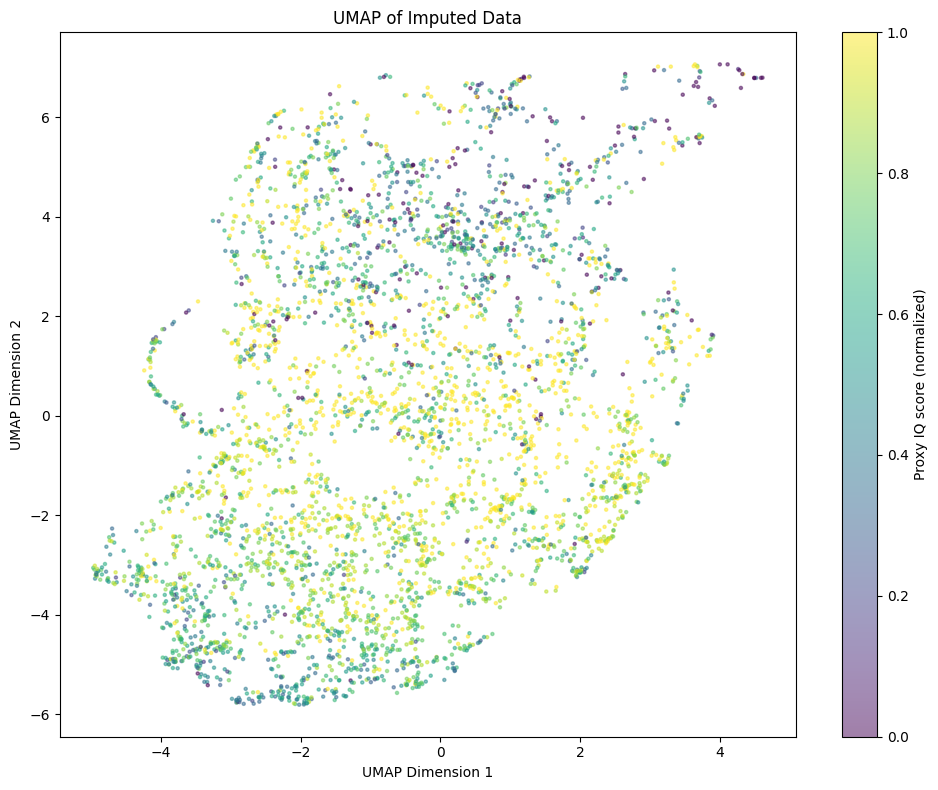

In [311]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(umap_features.values[:, 0], umap_features.values[:, 1], 
                     c=IQ_SCORES[umap_features.index], cmap='viridis', 
                     alpha=0.5, s=5)
plt.colorbar(scatter, label='Proxy IQ score (normalized)')
plt.title('UMAP of Imputed Data')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.tight_layout()
plt.savefig("../outputs/iq_umap.pdf")
plt.show()

#### TEST using cpu instead of gpu

In [298]:
from umap import UMAP as UMAP2

umap2 = UMAP2(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
umap2_features = umap2.fit_transform(mca_features)
_for_plotting = umap2_features

/home/ubuntu/miniconda3/envs/rapids/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ubuntu/miniconda3/envs/rapids/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


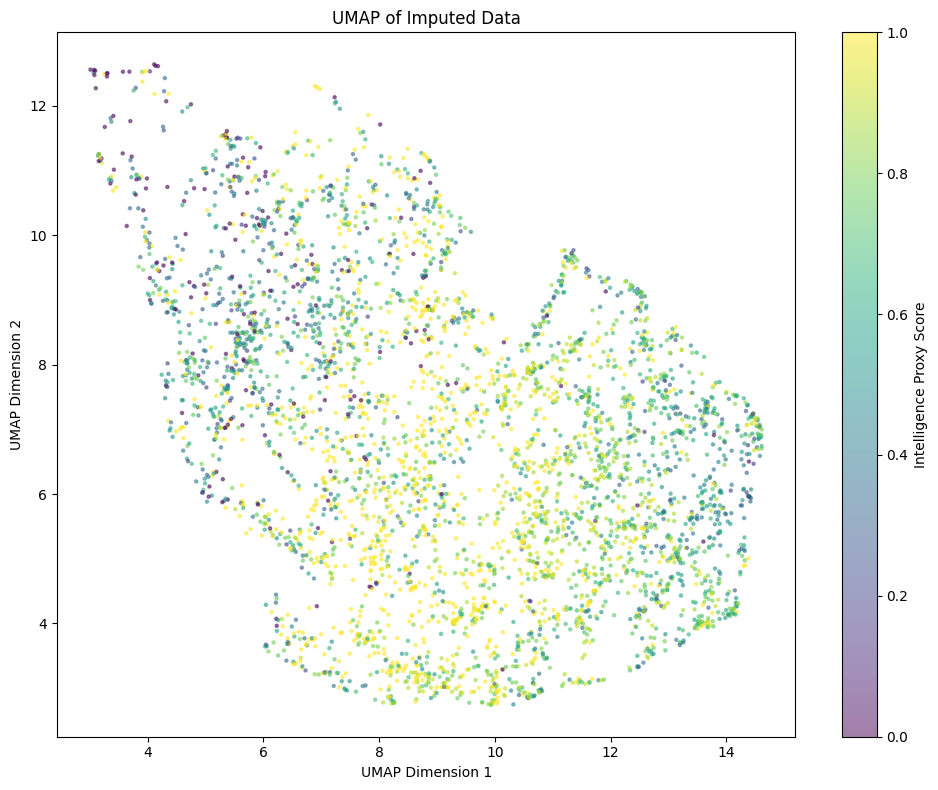

In [304]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(umap2_features[:, 0], umap2_features[:, 1], 
                     c=IQ_SCORES[mca_features.index], cmap='viridis', 
                     alpha=0.5, s=5)
plt.colorbar(scatter, label='Intelligence Proxy Score')
plt.title('UMAP of Imputed Data')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.tight_layout()
plt.savefig("../outputs/iq_indicator_umap2.pdf")
plt.show()

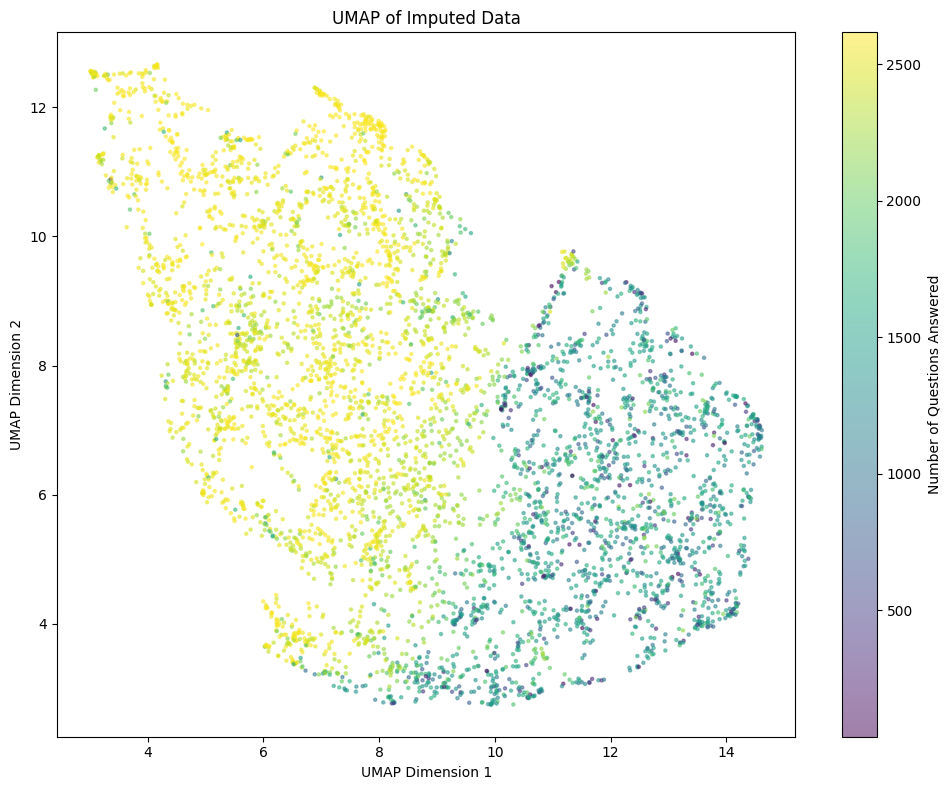

In [306]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(umap2_features[:, 0], umap2_features[:, 1], 
                     c=num_answered[mca_features.index], cmap='viridis', 
                     alpha=0.5, s=5)
plt.colorbar(scatter, label='Number of Questions Answered')
plt.title('UMAP of Imputed Data')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.tight_layout()
plt.savefig("../outputs/numanswered_indicator_umap2.pdf")
plt.show()

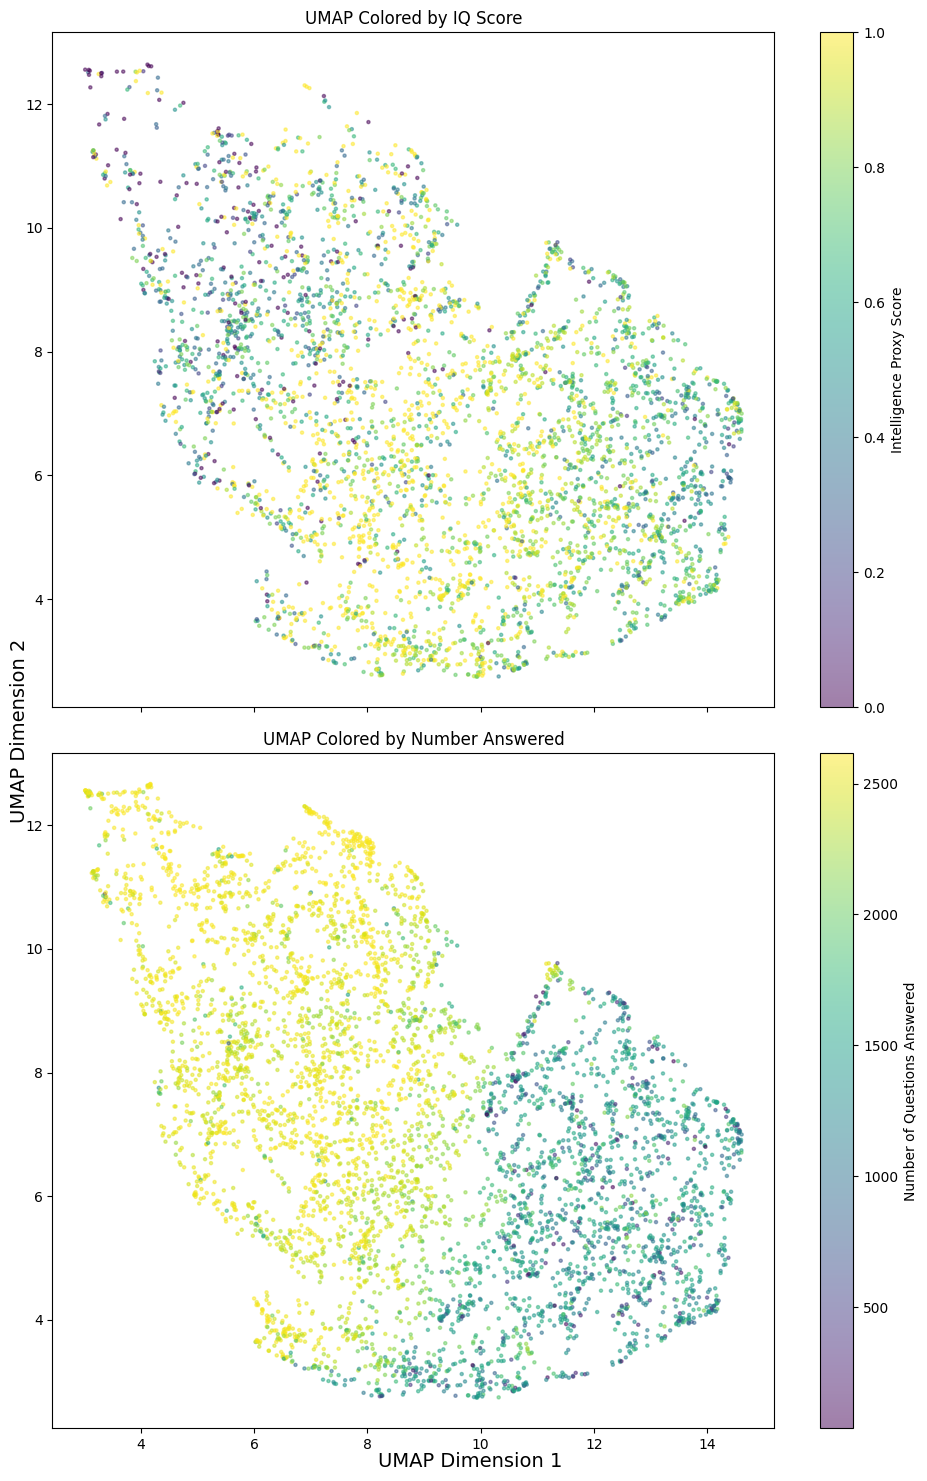

In [314]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(10, 16), sharex=True, sharey=True)

# First plot
sc1 = axs[0].scatter(
    umap2_features[:, 0], umap2_features[:, 1],
    c=IQ_SCORES[mca_features.index], cmap='viridis', alpha=0.5, s=5
)
fig.colorbar(sc1, ax=axs[0], label='Intelligence Proxy Score')
axs[0].set_title('UMAP Colored by IQ Score')

# Second plot
sc2 = axs[1].scatter(
    umap2_features[:, 0], umap2_features[:, 1],
    c=num_answered[mca_features.index], cmap='viridis', alpha=0.5, s=5
)
fig.colorbar(sc2, ax=axs[1], label='Number of Questions Answered')
axs[1].set_title('UMAP Colored by Number Answered')

# Shared labels and title
fig.text(0.5, 0.04, 'UMAP Dimension 1', ha='center', fontsize=14)
fig.text(0.04, 0.5, 'UMAP Dimension 2', va='center', rotation='vertical', fontsize=14)

plt.tight_layout(rect=[0.04, 0.04, 1, 0.96])
plt.savefig("../outputs/umap2_vertical_combined.pdf")
plt.show()

### pearson

-0.12206785391833287 8.659820607521237e-187


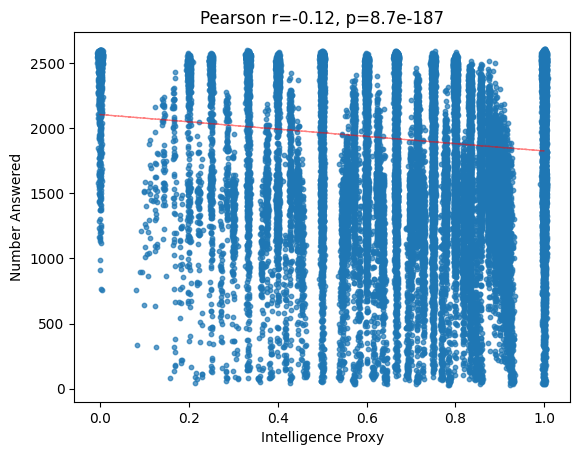

In [317]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import numpy as np

# Jitter function
def jitter(arr, frac=0.002):
    return arr + np.random.normal(0, frac * (np.max(arr) - np.min(arr)), arr.shape)

mask1 = IQ_SCORES.notna()
mask2 = ~np.isnan(num_answered)
mask = mask1 & mask2

x = IQ_SCORES[mask].values
y = num_answered[mask]

r, p_value = pearsonr(x, y)
print(r, p_value)

plt.scatter(jitter(x), jitter(y), s=10, alpha=0.7)  # smaller dots, jittered

# Plot regression line
m, b = np.polyfit(x, y, 1)
plt.plot(
    x, m * x + b,
    linestyle="--", linewidth=1, color="red", alpha=0.5
)

plt.xlabel("Intelligence Proxy")
plt.ylabel("Number Answered")
plt.title(f"Pearson r={r:.2f}, p={p_value:.2g}")
plt.savefig('../outputs/pearson_chart.pdf')
plt.show()